In [3]:
pip install numpyro

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

matplotlib.use("Agg")  # noqa: E402

In [5]:
from scipy.stats import lognorm

# Define parameters for the log-normal distribution
mean = 1.1567  # Mean of the distribution
sigma = 0.05  # Standard deviation of the logarithm of the distribution

# Create a log-normal distribution object
Theta_crit_prior = lognorm(s=sigma, scale=mean)
x = np.linspace(0.9, 2, 1000)
pdf = Theta_crit_prior.pdf(x)
plt.plot(x, pdf, 'r-', lw=2, label='PDF')

plt.title('Prior $\Theta_{{crit}}$ Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
##Read in the data sets needed. X_1 and X_2 are the training feature data for
##the GPs. Y_1 are the labels for the first GP regression (area estimates), Y_2 are the
##labels for the second GP regression (distance errors)
##########################
#Read in training data X_1, X_2
file_path = 'Ped_1_GP_Training_Data_Features_X.txt'

X_1 = np.loadtxt(file_path)
X_2 = X_1
#########################
#Read in training labels Y_1 for the Area Growth Values Ag for the 100 tests
file_path = 'Ped_1_GP_Training_Data_Labels_Y1.txt'

Y_1 = np.loadtxt(file_path)

##########################
#Read in training labels Y_2 for the Mean Distance Errors for the 100 tests
file_path = 'Ped_1_GP_Training_Data_Labels_Y2.txt'

# Read the data from the file
Y_2 = np.loadtxt(file_path)

#############################
#Read in test data X_Test (just a copy of the training features data for now)
file_path = 'Ped_1_GP_Testing_Data_Features_X.txt'

X_test = np.loadtxt(file_path)
#############################
#Read in test data results Y_Test_1 for the area growth Ag
file_path = 'Ped_1_GP_Testing_Data_Labels_Y1.txt'

Y_test_1 = np.loadtxt(file_path)
#############################
#Read in test data results Y_test_2 for the mean error
file_path = 'Ped_1_GP_Testing_Data_Labels_Y2.txt'

Y_test_2 = np.loadtxt(file_path)

In [7]:
### Define the Kernel
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes
    a covariance matrix from points in X1 and X2.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [8]:
#Compute GP
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution
    from m training data X_train and Y_train and n new inputs X_s.

    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.

    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)

    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Create a Gaussian Process Regressor object
gp_1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the Gaussian Process Regressor
gp_1.fit(X_1, Y_1)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

[2.22989004e-25 1.27246439e-41 3.67303587e-51 1.60791306e-33
 7.32377207e-24 3.17617535e-71 3.25011555e-60 1.07575893e-24
 2.24188020e-47 4.91232769e-29 2.70237913e-16 4.39176052e-51
 5.66722452e-31 3.82431085e-79 2.67660464e-10 1.77183032e-65
 2.02463483e-04 2.55132940e-62 2.93578793e-16 1.38943832e-31
 1.64217386e-41 2.68197156e-41 2.73660871e-25 1.25478840e-47]


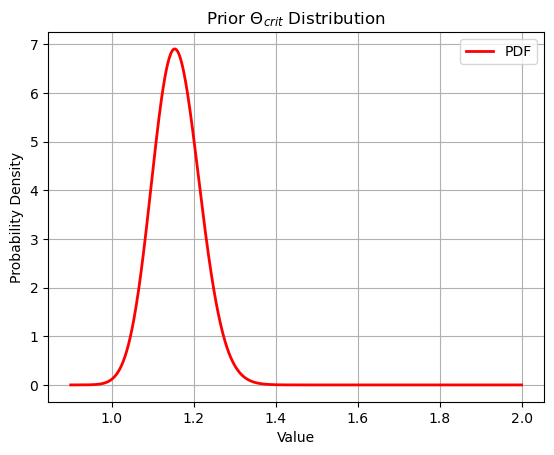

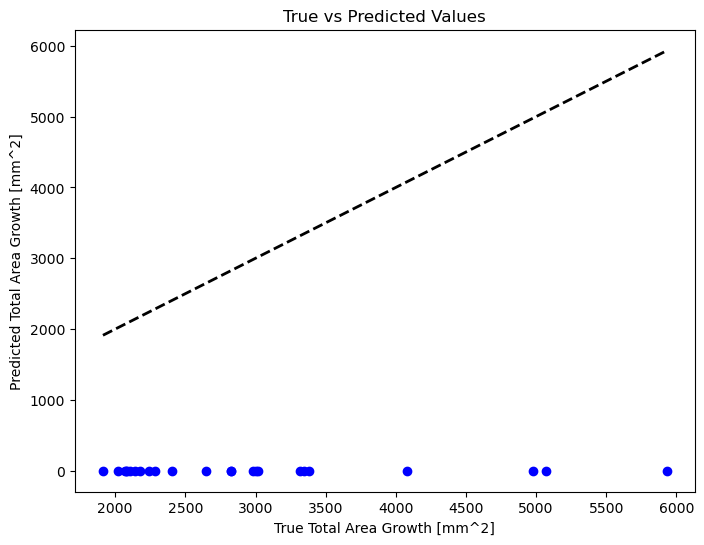

In [10]:
x_pred = X_test
#np.random.rand(100, 5)  # Generate new input data for prediction
y_pred, sigma = gp_1.predict(x_pred, return_std=True)
print(y_pred)
# Plot the results (since the output dimensionality is 1, it's difficult to visualize)
# Instead, you can plot the predicted values against the true values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_1, y_pred, color='blue')
plt.plot([Y_test_1.min(), Y_test_1.max()], [Y_test_1.min(), Y_test_1.max()], 'k--', lw=2)
plt.xlabel('True Total Area Growth [mm^2]')
plt.ylabel('Predicted Total Area Growth [mm^2]')
plt.title('True vs Predicted Values')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

mse = mean_squared_error(Y_test_1, y_pred)

# Compute the root mean squared error
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse} mm^2")

r_squared = r2_score(Y_test_1, y_pred)

print("R-squared (R²):", r_squared)

Root Mean Squared Error (RMSE): 3138.1796476611794 mm^2
R-squared (R²): -7.811508159597723


In [12]:
# Create a Gaussian Process Regressor object
gp_2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the Gaussian Process Regressor
gp_2.fit(X_2, Y_2) 

/apps/spack/negishi/apps/anaconda/2024.02-py311-gcc-8.5.0-lr57z2f/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

[1.77910751 1.77351433 1.75690871 1.75171108 1.92420991 1.83729216
 1.93183747 1.80449024 1.80555004 1.93389394 1.74110269 1.96448416
 1.72333285 1.95128477 1.89487164 1.88916596 1.86159952 1.99357769
 1.80265286 1.83153092 1.84161108 2.02979918 1.70346303 1.95000482]


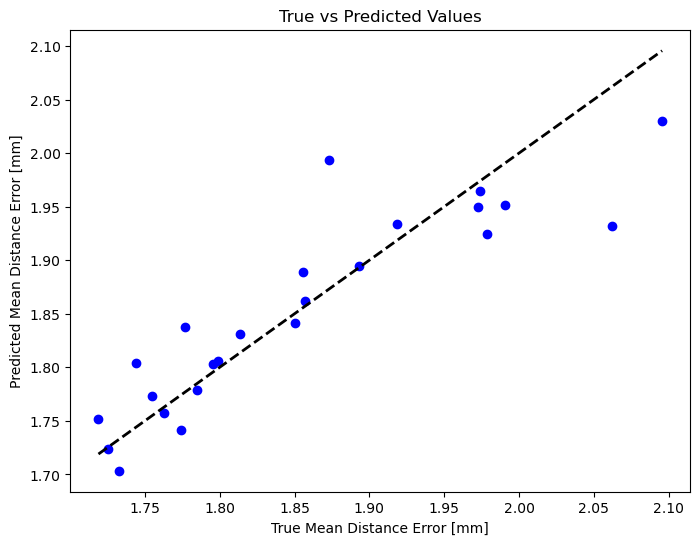

In [13]:
x_pred = X_test
#np.random.rand(100, 5)  # Generate new input data for prediction
y_pred_2, sigma = gp_2.predict(x_pred, return_std=True)
print(y_pred_2)
# Plot the results (since the output dimensionality is 1, it's difficult to visualize)
# Instead, you can plot the predicted values against the true values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_2, y_pred_2, color='blue')
plt.plot([Y_test_2.min(), Y_test_2.max()], [Y_test_2.min(), Y_test_2.max()], 'k--', lw=2)
plt.xlabel('True Mean Distance Error [mm]')
plt.ylabel('Predicted Mean Distance Error [mm]')
plt.title('True vs Predicted Values')
plt.show()

In [14]:
mse = mean_squared_error(Y_test_2, y_pred_2)

# Compute the root mean squared error
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse} mm")

r_squared = r2_score(Y_test_2, y_pred_2)

print("R-squared (R²):", r_squared)

Root Mean Squared Error (RMSE): 0.047235450978972235 mm
R-squared (R²): 0.8053135617617935


In [15]:
import numpy as np
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor

# Assuming you have a trained GaussianProcessRegressor model named 'gpr'
#tol_prior = uniform(loc=12, scale=25 - 12)
#h_prior = uniform(loc=2, scale=12 - 2)
#mu_prior = uniform(loc=0.0, scale = 1.0 - 0.0)
#Theta_crit_prior = uniform(loc=0.9, scale=2.2-0.9)
#kk_prior = kk_prior
# Define the bounds for the input variables, e.g., for a 2-dimensional input
bounds = [(X_1[:, 0].min(), X_1[:, 0].max()), (X_1[:, 1].min(), X_1[:, 1].max()), (X_1[:, 2].min(), X_1[:, 2].max()), (X_1[:, 3].min(), X_1[:, 3].max()), (X_1[:, 4].min(), X_1[:, 4].max())]
print(bounds)
# Define the objective function: the negative of the predicted mean
def objective_function(x):
    # Reshape x to be 2D array as expected by the predict method
    x = np.array(x).reshape(1, -1)
    # Predict the mean and standard deviation
    mean, std = gp_1.predict(x, return_std=True)
    # We want to minimize the mean, so return the negative mean
    return mean[0]

# Use an optimization algorithm to find the minimum
initial_guess = [14, 8, 0.5, 1.0, 1.0]
print(initial_guess)
#print(initial_guess.shape())# Ensure the initial guess is a 1D array of the correct shape
result = minimize(objective_function, x0=initial_guess, bounds=bounds)

# Get the minimum prediction value
min_prediction_value = gp_2.predict(result.x.reshape(1, -1))

print("Minimum prediction value:", min_prediction_value[0])
print("Input at minimum prediction value:", result.x)


[(12.171, 24.924), (2.41, 10.373), (0.104, 0.987), (1.104, 2.191), (0.656648136, 1.630759841)]
[14, 8, 0.5, 1.0, 1.0]
Minimum prediction value: 1.7000424845321902
Input at minimum prediction value: [14.     8.     0.5    1.104  1.   ]


In [16]:
!pip install scikit-learn
!pip install corner

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [38]:
#FUNCTION TO MAP GP OUTPUT INTO A LIKELIHOOD VALUE
def transform_gp_output(output):
    L_list = []
    for i in output:
        y = 4018.853198
        err_pred = i
        sigma_2 = 0.05
        #err_min = 1.3778578922247107
        err_min = 1.6782
        L = (1/(sigma_2*np.sqrt(2*np.pi)))*np.exp(-0.5 * np.sum(((err_pred-err_min)**2)/(sigma_2**2))),   # Likelihood function
        L_list.append(L)
    L_array = np.array(L_list)
    return L_array

[[12.171       2.41        0.56324     1.64951     1.0773913 ]
 [12.171       2.42595792  0.56324     1.64951     1.0773913 ]
 [12.171       2.44191583  0.56324     1.64951     1.0773913 ]
 ...
 [24.924      10.34108417  0.56324     1.64951     1.0773913 ]
 [24.924      10.35704208  0.56324     1.64951     1.0773913 ]
 [24.924      10.373       0.56324     1.64951     1.0773913 ]]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.37642229e-66
 3.07027570e-67 1.37634550e-68]
1.6227839483866404


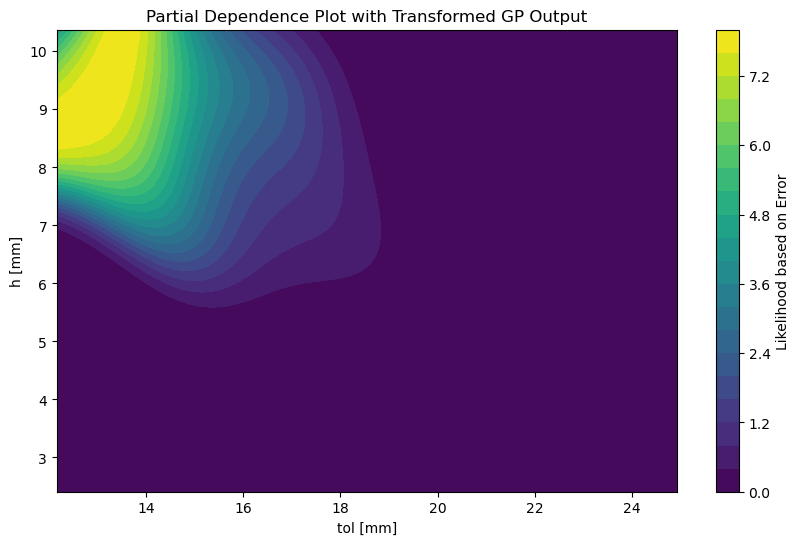

In [39]:
####TOL and H
##### Generate grid points for partial dependence
grid_size = 500

#Define Feature Ranges
feature_1_range = np.linspace(X_1[:, 0].min(), X_1[:, 0].max(), grid_size) #tol range
feature_2_range = np.linspace(X_1[:, 1].min(), X_1[:, 1].max(), grid_size) #h range
feature_3_range = np.linspace(X_1[:, 2].min(), X_1[:, 2].max(), grid_size) #mu range
feature_4_range = np.linspace(X_1[:, 3].min(), X_1[:, 3].max(), grid_size) #Theta crit range
feature_5_range = np.linspace(X_1[:, 4].min(), X_1[:, 4].max(), grid_size) #k range

#feature_4_range = np.linspace(1.2, 1.4, 500)
#feature_5_range = np.linspace(1.0, 2, 500)
#Define Grid Values for Feature 1
feature_1_grid, feature_2_grid = np.meshgrid(feature_2_range, feature_1_range)
# Fix the other features at their mean values
fixed_features = X_1.mean(axis=0)

# Create the grid for prediction
grid = np.array([
    [f1, f2, fixed_features[2], fixed_features[3], fixed_features[4]]
    for f1 in feature_1_range for f2 in feature_2_range
])

# Predict using the GP model
predictions = gp_2.predict(grid)
area_predictions = gp_1.predict(grid)
print(grid)
print(area_predictions)
print(min(predictions))
# Apply the transformation to the predictions
transformed_predictions = transform_gp_output(predictions)
#transform_gp_output(predictions)

# Reshape the transformed predictions to match the grid
transformed_predictions_grid = transformed_predictions.reshape(grid_size, grid_size)

# Plot the partial dependence plot
plt.figure(figsize=(10, 6))
plt.contourf(feature_2_grid, feature_1_grid, transformed_predictions_grid, levels=25, cmap='viridis')
plt.colorbar(label='Likelihood based on Error')
plt.xlabel('tol [mm]')
plt.ylabel('h [mm]')
plt.title('Partial Dependence Plot with Transformed GP Output')
plt.show()

In [32]:
gp_1.predict(np.array([12.171, 8.41, 0.56324, 1.14951, 1.0773913]).reshape(1,-1))


array([2.47732035e-21])

1.7169265928235973


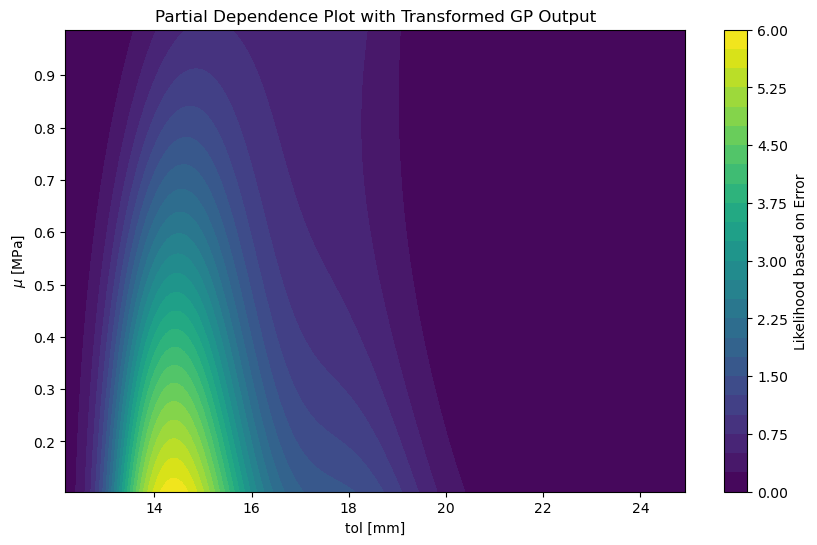

In [40]:
###TOL and MU
##### Generate grid points for partial dependence
grid_size = 500

#Define Feature Ranges
feature_1_range = np.linspace(X_1[:, 0].min(), X_1[:, 0].max(), grid_size) #tol range
feature_2_range = np.linspace(X_1[:, 1].min(), X_1[:, 1].max(), grid_size) #h range
feature_3_range = np.linspace(X_1[:, 2].min(), X_1[:, 2].max(), grid_size) #mu range
feature_4_range = np.linspace(X_1[:, 3].min(), X_1[:, 3].max(), grid_size) #Theta crit range
feature_5_range = np.linspace(X_1[:, 4].min(), X_1[:, 4].max(), grid_size) #k range

#feature_4_range = np.linspace(1.2, 1.4, 500)
#feature_5_range = np.linspace(1.0, 2, 500)
#Define Grid Values for Feature 1
feature_1_grid, feature_3_grid = np.meshgrid(feature_3_range, feature_1_range)
# Fix the other features at their mean values
fixed_features = X_1.mean(axis=0)

# Create the grid for prediction
grid = np.array([
    [f1, fixed_features[1], f3, fixed_features[3], fixed_features[4]]
    for f1 in feature_1_range for f3 in feature_3_range
])

# Predict using the GP model
predictions = gp_2.predict(grid)
print(min(predictions))
# Apply the transformation to the predictions
transformed_predictions = transform_gp_output(predictions)

# Reshape the transformed predictions to match the grid
transformed_predictions_grid = transformed_predictions.reshape(grid_size, grid_size)

# Plot the partial dependence plot
plt.figure(figsize=(10, 6))
plt.contourf(feature_3_grid, feature_1_grid, transformed_predictions_grid, levels=25, cmap='viridis')
plt.colorbar(label='Likelihood based on Error')
plt.xlabel('tol [mm]')
plt.ylabel('$\mu$ [MPa]')
plt.title('Partial Dependence Plot with Transformed GP Output')
plt.show()

In [34]:
gp_2.predict(np.array([15, fixed_features[1], 0.9, fixed_features[3], fixed_features[4]]).reshape(1,-1))

array([1.77943625])

1.7362025709654745


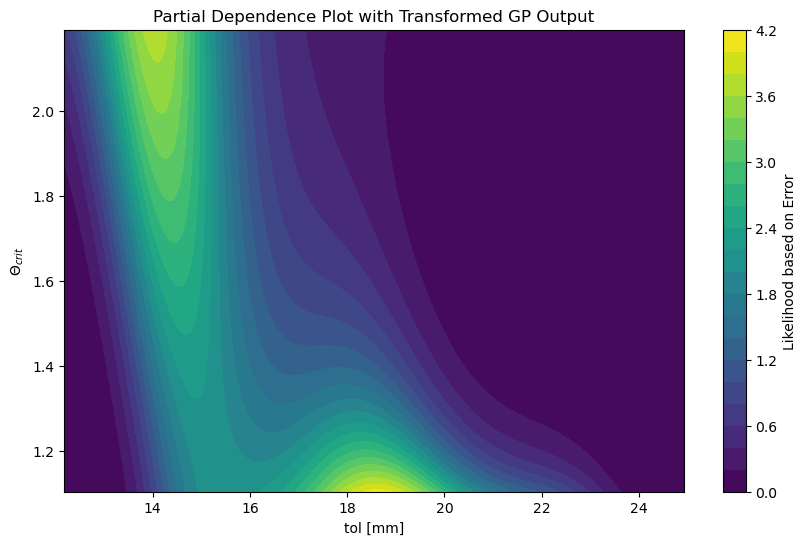

In [41]:
####TOL and THETA CRIT
##### Generate grid points for partial dependence
grid_size = 500

#Define Feature Ranges
feature_1_range = np.linspace(X_1[:, 0].min(), X_1[:, 0].max(), grid_size) #tol range
feature_2_range = np.linspace(X_1[:, 1].min(), X_1[:, 1].max(), grid_size) #h range
feature_3_range = np.linspace(X_1[:, 2].min(), X_1[:, 2].max(), grid_size) #mu range
feature_4_range = np.linspace(X_1[:, 3].min(), X_1[:, 3].max(), grid_size) #Theta crit range
feature_5_range = np.linspace(X_1[:, 4].min(), X_1[:, 4].max(), grid_size) #k range

#feature_4_range = np.linspace(1.2, 1.4, 500)
#feature_5_range = np.linspace(1.0, 2, 500)
#Define Grid Values for Feature 1
feature_1_grid, feature_4_grid = np.meshgrid(feature_4_range, feature_1_range)
# Fix the other features at their mean values
fixed_features = X_1.mean(axis=0)

# Create the grid for prediction
grid = np.array([
    [f1, fixed_features[1], fixed_features[2], f4, fixed_features[4]]
    for f1 in feature_1_range for f4 in feature_4_range
])

# Predict using the GP model
predictions = gp_2.predict(grid)
print(min(predictions))
# Apply the transformation to the predictions
transformed_predictions = transform_gp_output(predictions)
#transform_gp_output(predictions)

# Reshape the transformed predictions to match the grid
transformed_predictions_grid = transformed_predictions.reshape(grid_size, grid_size)

# Plot the partial dependence plot
plt.figure(figsize=(10, 6))
plt.contourf(feature_4_grid, feature_1_grid, transformed_predictions_grid, levels=25, cmap='viridis')
plt.colorbar(label='Likelihood based on Error')
plt.xlabel('tol [mm]')
plt.ylabel('$\Theta_{{crit}}$')
plt.title('Partial Dependence Plot with Transformed GP Output')
plt.show()

1.7201407600989


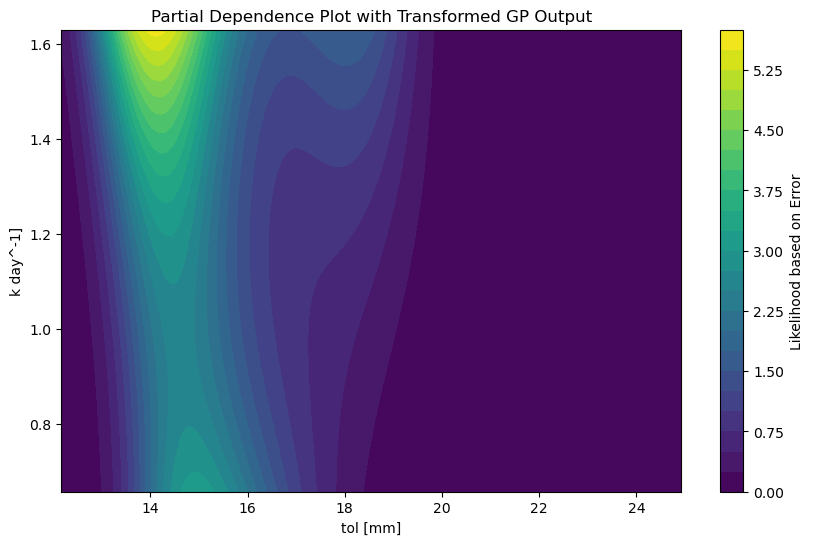

In [42]:
#####TOL and K
##### Generate grid points for partial dependence
grid_size = 500

#Define Feature Ranges
feature_1_range = np.linspace(X_1[:, 0].min(), X_1[:, 0].max(), grid_size) #tol range
feature_2_range = np.linspace(X_1[:, 1].min(), X_1[:, 1].max(), grid_size) #h range
feature_3_range = np.linspace(X_1[:, 2].min(), X_1[:, 2].max(), grid_size) #mu range
feature_4_range = np.linspace(X_1[:, 3].min(), X_1[:, 3].max(), grid_size) #Theta crit range
feature_5_range = np.linspace(X_1[:, 4].min(), X_1[:, 4].max(), grid_size) #k range

#feature_4_range = np.linspace(1.2, 1.4, 500)
#feature_5_range = np.linspace(1.0, 2, 500)
#Define Grid Values for Feature 1
feature_1_grid, feature_5_grid = np.meshgrid(feature_5_range, feature_1_range)
# Fix the other features at their mean values
fixed_features = X_1.mean(axis=0)

# Create the grid for prediction
grid = np.array([
    [f1, fixed_features[1], fixed_features[2], fixed_features[3], f5]
    for f1 in feature_1_range for f5 in feature_5_range
])

# Predict using the GP model
predictions = gp_2.predict(grid)
print(min(predictions))
# Apply the transformation to the predictions
transformed_predictions = transform_gp_output(predictions)
#transform_gp_output(predictions)

# Reshape the transformed predictions to match the grid
transformed_predictions_grid = transformed_predictions.reshape(grid_size, grid_size)

# Plot the partial dependence plot
plt.figure(figsize=(10, 6))
plt.contourf(feature_3_grid, feature_1_grid, transformed_predictions_grid, levels=25, cmap='viridis')
plt.colorbar(label='Likelihood based on Error')
plt.xlabel('tol [mm]')
plt.ylabel('k day^-1]')
plt.title('Partial Dependence Plot with Transformed GP Output')
plt.show()

1.7169265928235973


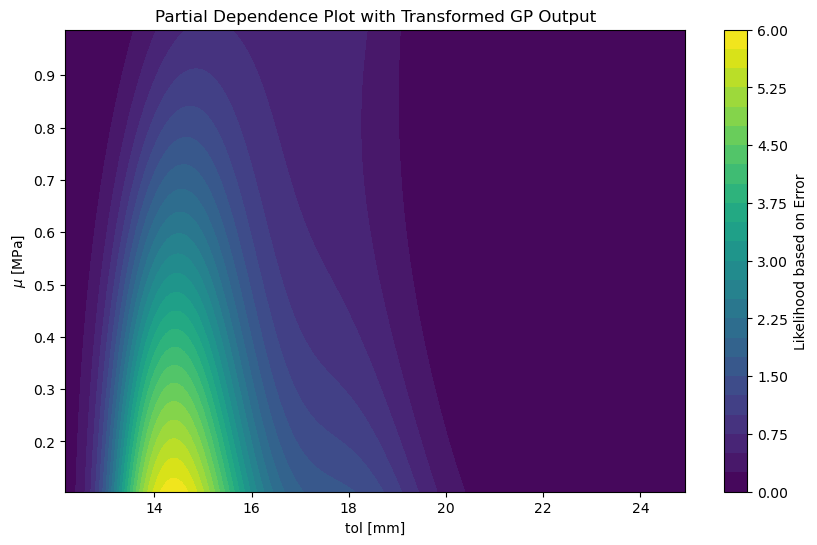

In [43]:
##### Generate grid points for partial dependence
grid_size = 500

#Define Feature Ranges
feature_1_range = np.linspace(X_1[:, 0].min(), X_1[:, 0].max(), grid_size) #tol range
feature_2_range = np.linspace(X_1[:, 1].min(), X_1[:, 1].max(), grid_size) #h range
feature_3_range = np.linspace(X_1[:, 2].min(), X_1[:, 2].max(), grid_size) #mu range
feature_4_range = np.linspace(X_1[:, 3].min(), X_1[:, 3].max(), grid_size) #Theta crit range
feature_5_range = np.linspace(X_1[:, 4].min(), X_1[:, 4].max(), grid_size) #k range

#feature_4_range = np.linspace(1.2, 1.4, 500)
#feature_5_range = np.linspace(1.0, 2, 500)
#Define Grid Values for Feature 1
feature_1_grid, feature_3_grid = np.meshgrid(feature_3_range, feature_1_range)
# Fix the other features at their mean values
fixed_features = X_1.mean(axis=0)

# Create the grid for prediction
grid = np.array([
    [f1, fixed_features[1], f3, fixed_features[3], fixed_features[4]]
    for f1 in feature_1_range for f3 in feature_3_range
])

# Predict using the GP model
predictions = gp_2.predict(grid)
print(min(predictions))
# Apply the transformation to the predictions
transformed_predictions = transform_gp_output(predictions)
#transform_gp_output(predictions)

# Reshape the transformed predictions to match the grid
transformed_predictions_grid = transformed_predictions.reshape(grid_size, grid_size)

# Plot the partial dependence plot
plt.figure(figsize=(10, 6))
plt.contourf(feature_3_grid, feature_1_grid, transformed_predictions_grid, levels=25, cmap='viridis')
plt.colorbar(label='Likelihood based on Error')
plt.xlabel('tol [mm]')
plt.ylabel('$\mu$ [MPa]')
plt.title('Partial Dependence Plot with Transformed GP Output')
plt.show()

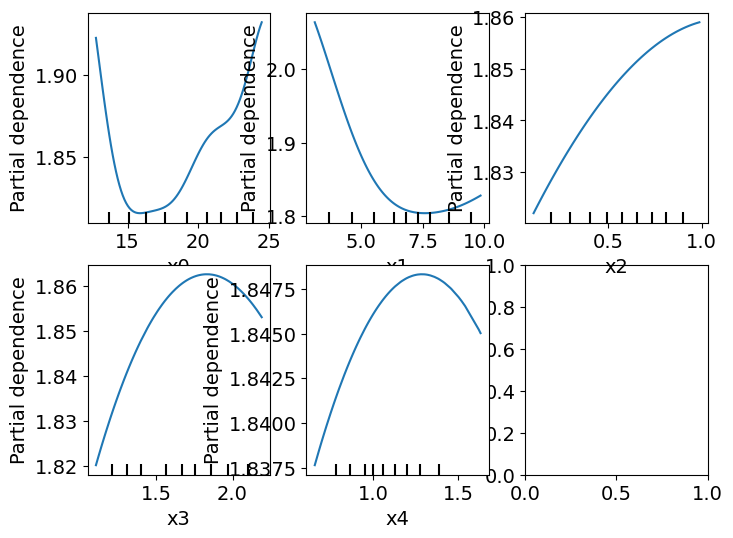

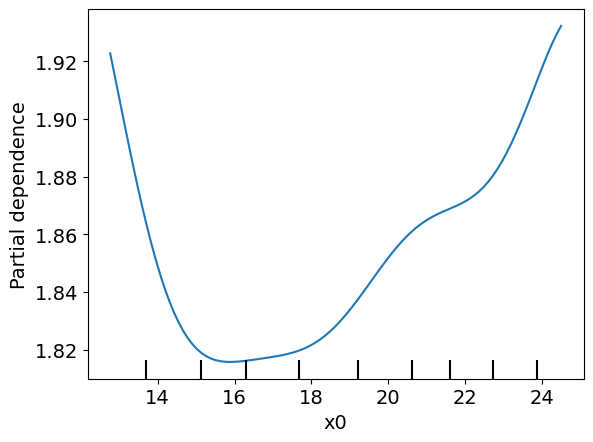

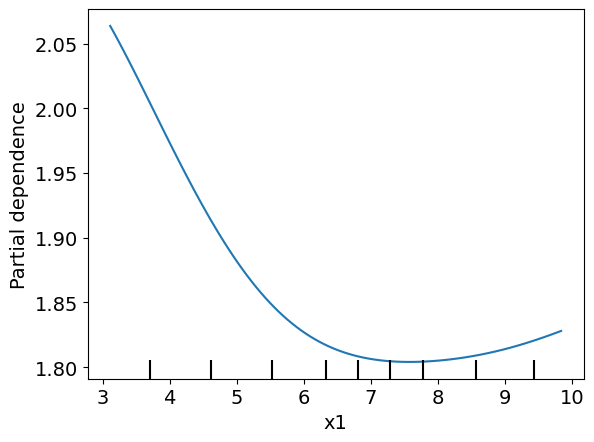

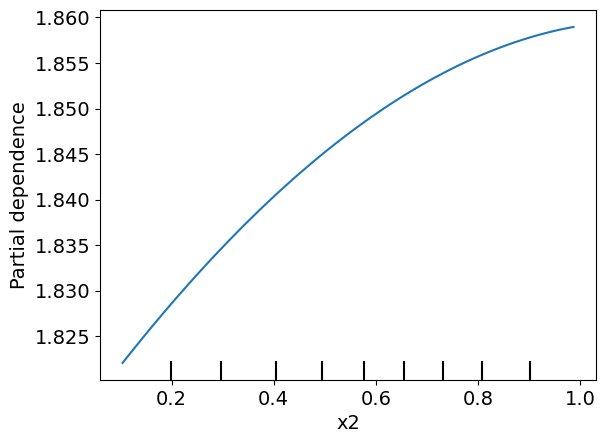

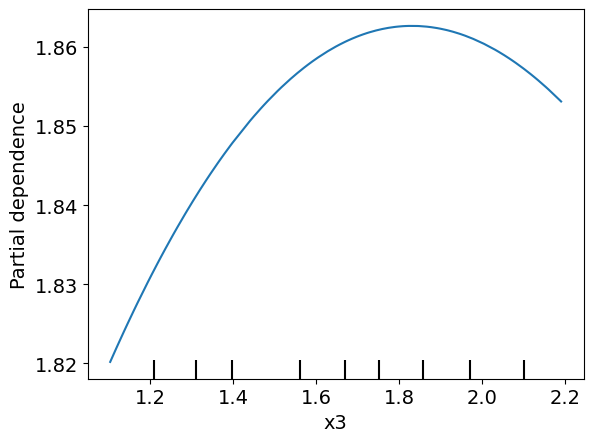

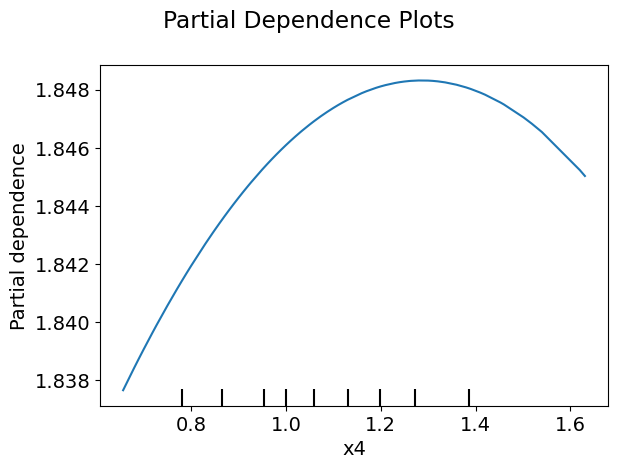

In [53]:
import sklearn.inspection
from sklearn.inspection import PartialDependenceDisplay



# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 3, figsize=(8, 6))

x_ranges = [(10, 30), (0, 12), (0.0, 2.0), (0, 3), (0, 2)]

# Plot partial dependence for each feature
for i, ax in enumerate(axs.flat):
    if i <5:
      display = PartialDependenceDisplay.from_estimator(gp_2, X_2, features=[i])
      display.plot(ax=ax)

      # Set custom x-axis range for each subplot
      ax.set_xlim(x_ranges[i])

plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
plt.show()

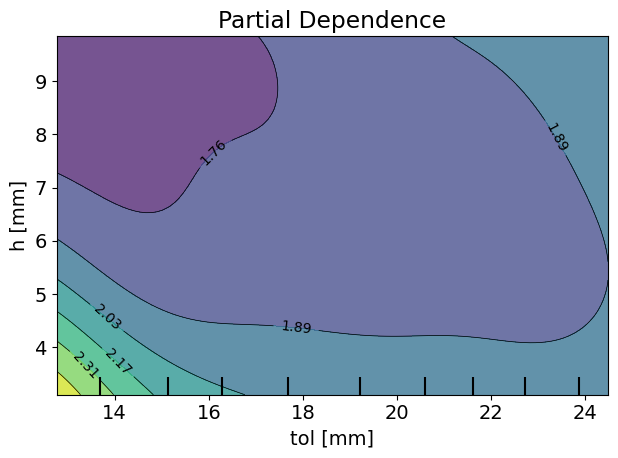

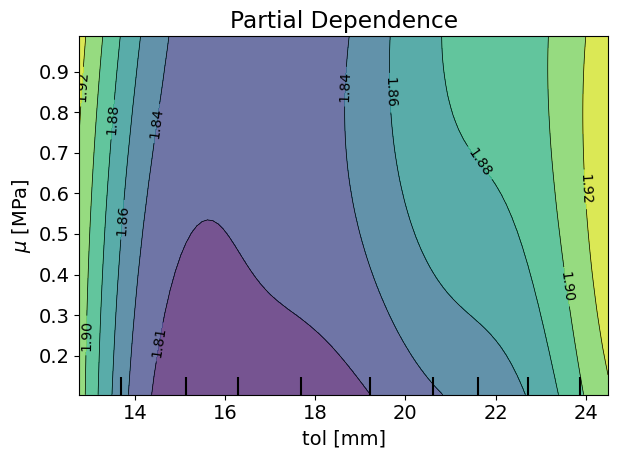

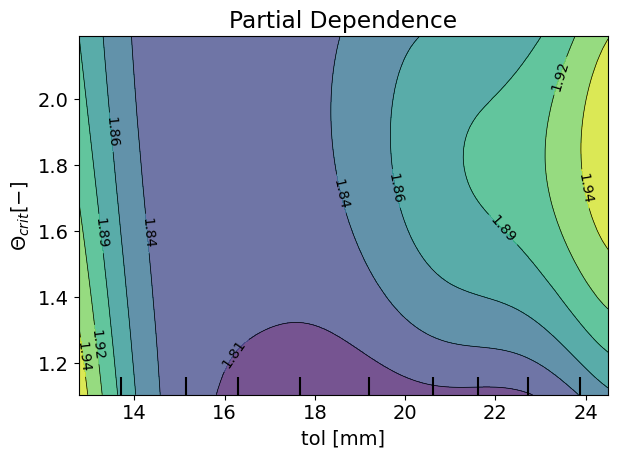

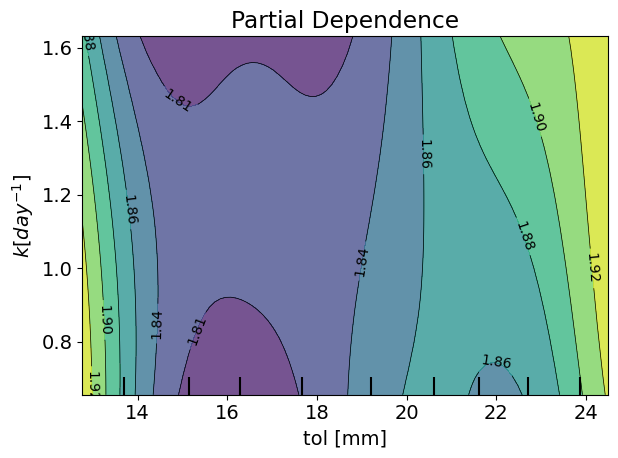

In [54]:
#####Tol Partial Dependencies Contour Plots
#Figure 1 tol and h partial dependence

PartialDependenceDisplay.from_estimator(gp_2, X_2, [(0, 1)])
plt.rc('font', size=14)
plt.xlabel('tol [mm]')
plt.ylabel('h [mm]')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()


#Figure 2 tol and mu
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(0, 2)])
plt.rc('font', size=14)
plt.xlabel('tol [mm]')
plt.ylabel('$\mu$ [MPa]')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()

#Figure 3 tol and theta crit
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(0, 3)])
plt.rc('font', size=14)
plt.xlabel('tol [mm]')
plt.ylabel('$\Theta_{crit} [-]$')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()

#Figure 4 tol and k
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(0, 4)])
plt.rc('font', size=14)
plt.xlabel('tol [mm]')
plt.ylabel('$k [day^{-1}]$')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()


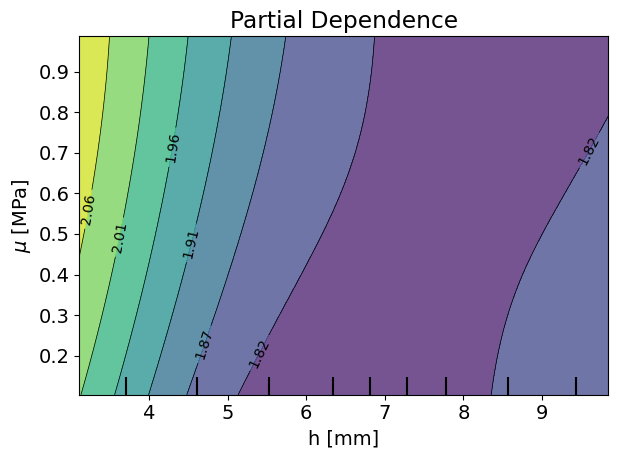

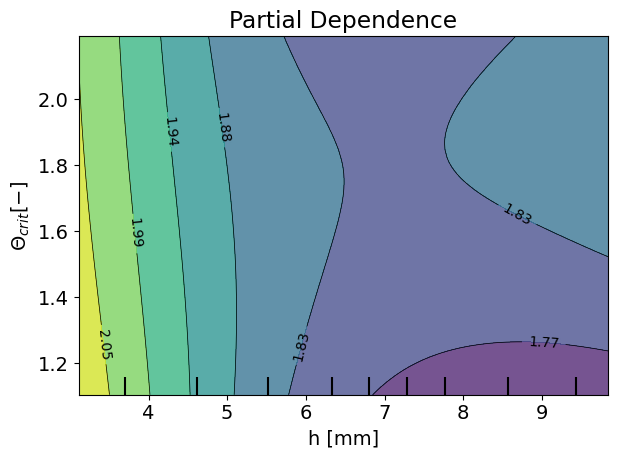

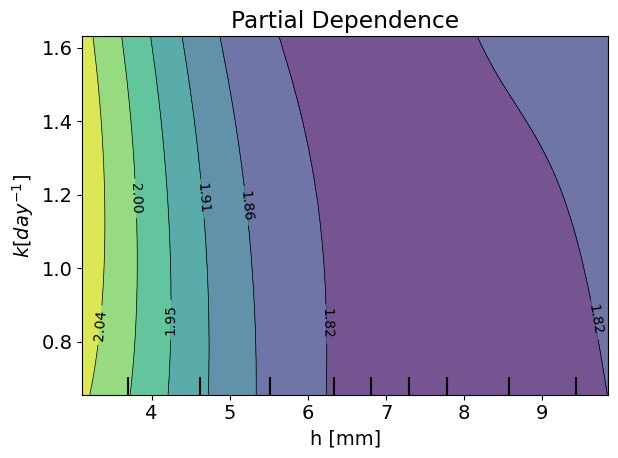

In [55]:
#####h Partial Dependencies Contour Plots
#Figure 1 tol and h partial dependence
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(1, 2)])
plt.rc('font', size=14)
plt.xlabel('h [mm]')
plt.ylabel('$\mu$ [MPa]')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()


#Figure 2 tol and mu
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(1, 3)])
plt.rc('font', size=14)
plt.xlabel('h [mm]')
plt.ylabel('$\Theta_{crit} [-]$')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()

#Figure 3 tol and theta crit
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(1, 4)])
plt.rc('font', size=14)
plt.xlabel('h [mm]')
plt.ylabel('$k [day^{-1}]$')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()


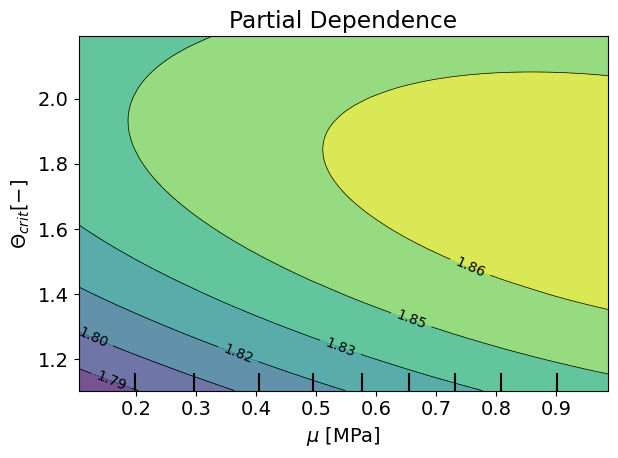

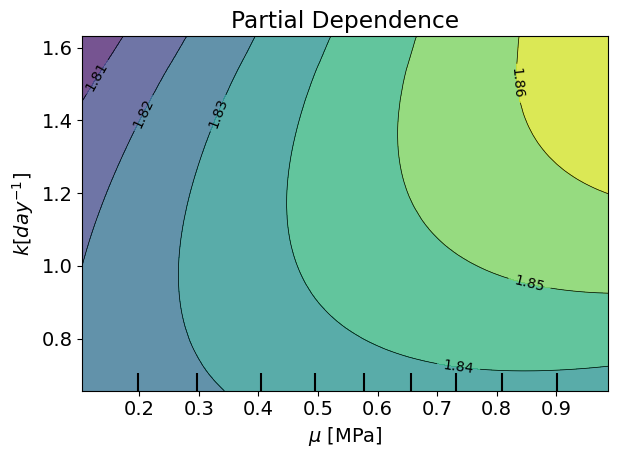

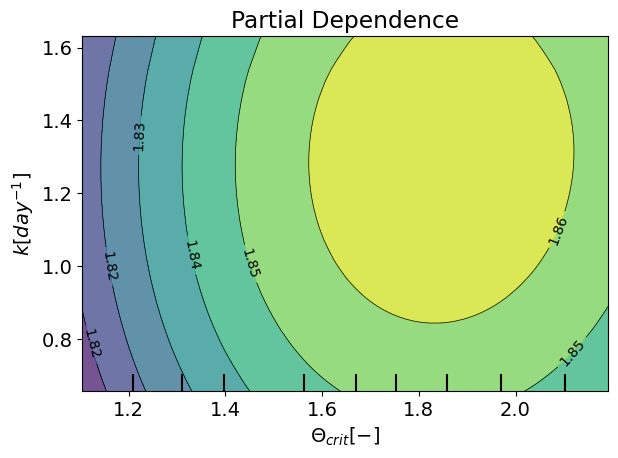

In [56]:
#Figure 2 tol and mu
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(2, 3)])
plt.rc('font', size=14)
plt.xlabel('$\mu$ [MPa]')
plt.ylabel('$\Theta_{crit} [-]$')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()

#Figure 3 tol and theta crit
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(2, 4)])
plt.rc('font', size=14)
plt.xlabel('$\mu$ [MPa]')
plt.ylabel('$k [day^{-1}]$')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()

#Figure tcrit and k
PartialDependenceDisplay.from_estimator(gp_2, X_2, [(3, 4)])
plt.rc('font', size=14)
plt.xlabel('$\Theta_{crit} [-]$')
plt.ylabel('$k [day^{-1}]$')
plt.title('Partial Dependence')
plt.tight_layout()
plt.show()

In [57]:
pip install emcee

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [58]:
from sklearn.mixture import GaussianMixture
class CustomGMM:
    def __init__(self, n_components=1, **kwargs):
        self.gmm = GaussianMixture(n_components=n_components, **kwargs)

    def fit(self, X):
        self.gmm.fit(X)

    def pdf(self, X):

        return np.exp(self.gmm.score_samples(np.array(X).reshape(-1, 1)))

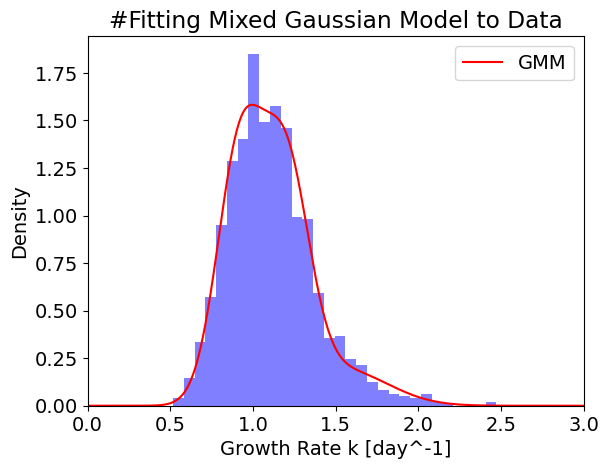

In [59]:
## Fit a Gaussian Mixture to Tina's Distribution
from sklearn.mixture import GaussianMixture
%matplotlib inline

with open("Tina_kk_distribution_day_inverse.txt", 'r') as file:
   lines = file.readlines()

data = []
for line in lines:
    # Assuming each line contains one data point
    data_point = float(line.strip())  # Convert string to float
    data.append(data_point)

# Convert the list to a NumPy array if needed
import numpy as np
data_array = np.array(data)

gmm_data = data_array.reshape(-1,1)

# Fit a Gaussian Mixture Model
gmm = CustomGMM(n_components=3, random_state=42)
gmm.fit(gmm_data)

#Fit a second GMM without using the custom class fix to sample from it directly
gmm_2 = GaussianMixture(n_components=3, random_state=42)
gmm_2.fit(gmm_data)

# Generate data points for plotting
x = np.linspace(0, 300, 1000000)
# Compute the log-density of the Gaussian mixture model at each point
density = gmm.pdf(x)

# Plot the data and the fitted Gaussian mixture model
plt.hist(data, bins=30, density=True, alpha=0.5, color='blue')

plt.plot(x, density, color='red', label='GMM')
plt.xlim([0,3])
plt.xlabel('Growth Rate k [day^-1]')
plt.ylabel('Density')
plt.title('#Fitting Mixed Gaussian Model to Data')
plt.legend()
plt.show()
plt.show()

kk_prior = gmm

In [60]:
starting_k_samples, __ = gmm_2.sample(100)
starting_k_samples = starting_k_samples.flatten().tolist()
print(starting_k_samples)

[1.0435241749380784, 1.2440563384329915, 1.2384696108124307, 1.3409897929513173, 1.1179470808355452, 1.1257549152528556, 1.1192782743527008, 1.0698450169312737, 0.8331970136658847, 1.3325600494796233, 1.3137897655435458, 0.985780641961087, 1.1393673525004018, 1.0953079272505784, 1.1007828307273817, 0.8994805750079571, 1.1111359630164646, 1.283134284287668, 1.5580870099090398, 1.254614377717338, 1.2164901102647085, 1.127119210275288, 1.115231465568404, 1.3321494129808455, 1.2401504562420795, 1.1102831470673233, 1.056184139953729, 1.176689484337906, 1.124566536320495, 1.1985856479546764, 1.1672016410059052, 1.2539298425038836, 1.0220468703083117, 1.352409248554853, 1.588756562294038, 1.3666557100979326, 1.230003794968204, 1.3229441633459849, 1.057931439148545, 0.9774528457849223, 1.029005206238235, 0.846897796374529, 0.7346583138186698, 0.7993595968568593, 0.76466048325263, 0.9402627537723086, 1.0024107669195794, 1.0448371375411176, 1.0457510978615645, 1.0264089443353448, 0.8928432203505

(0.0, 3.0)

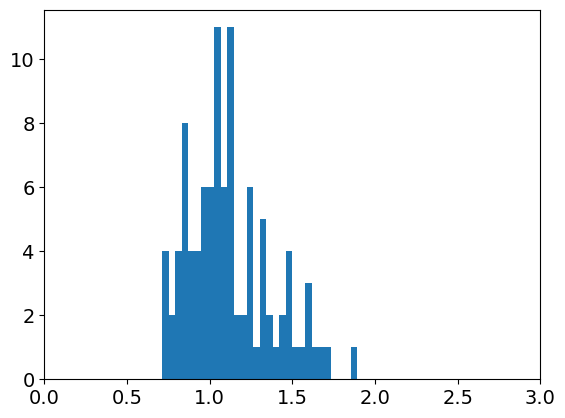

In [61]:
#Encodes the starting sample information for the walkers that sample on the k prior
plt.figure()
plt.hist(starting_k_samples, bins=30)
plt.xlim([0,3])

In [62]:
hyperparameters = gp_1.kernel_.get_params()

# Print the length scale
print(hyperparameters)

hyperparameters_2 = gp_2.kernel_.get_params()

print(hyperparameters_2)

{'k1': 1.29e+04**2, 'k2': RBF(length_scale=3.28), 'k1__constant_value': 165614447.311946, 'k1__constant_value_bounds': (0.001, 10000000000.0), 'k2__length_scale': 3.2832825492334408, 'k2__length_scale_bounds': (0.01, 100.0)}
{'k1': 1.09**2, 'k2': RBF(length_scale=3.53), 'k1__constant_value': 1.1940764837457671, 'k1__constant_value_bounds': (0.001, 10000000000.0), 'k2__length_scale': 3.527862184789044, 'k2__length_scale_bounds': (0.01, 100.0)}


In [63]:
gp_1._get_param_names()

['alpha',
 'copy_X_train',
 'kernel',
 'n_restarts_optimizer',
 'normalize_y',
 'optimizer',
 'random_state']

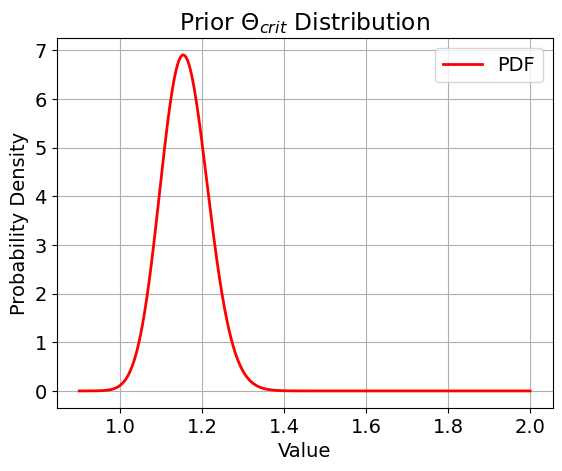

In [64]:
from scipy.stats import lognorm

# Define parameters for the log-normal distribution
mean = 1.1567  # Mean of the distribution
sigma = 0.05  # Standard deviation of the logarithm of the distribution

# Create a log-normal distribution object
Theta_crit_prior = lognorm(s=sigma, scale=mean)
x = np.linspace(0.9, 2, 1000)
pdf = Theta_crit_prior.pdf(x)
plt.plot(x, pdf, 'r-', lw=2, label='PDF')

plt.title('Prior $\Theta_{{crit}}$ Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
#code to fix how the gmm pdf evaluates probability densities
def extract_first_item(obj):
    if isinstance(obj, np.ndarray) and obj.size > 0:
        return obj[0]
    else:
        return obj

Completed 1000 steps out of 10000
Completed 2000 steps out of 10000
Completed 3000 steps out of 10000
Completed 4000 steps out of 10000
Completed 5000 steps out of 10000
Completed 6000 steps out of 10000
Completed 7000 steps out of 10000
Completed 8000 steps out of 10000
Completed 9000 steps out of 10000
Completed 10000 steps out of 10000


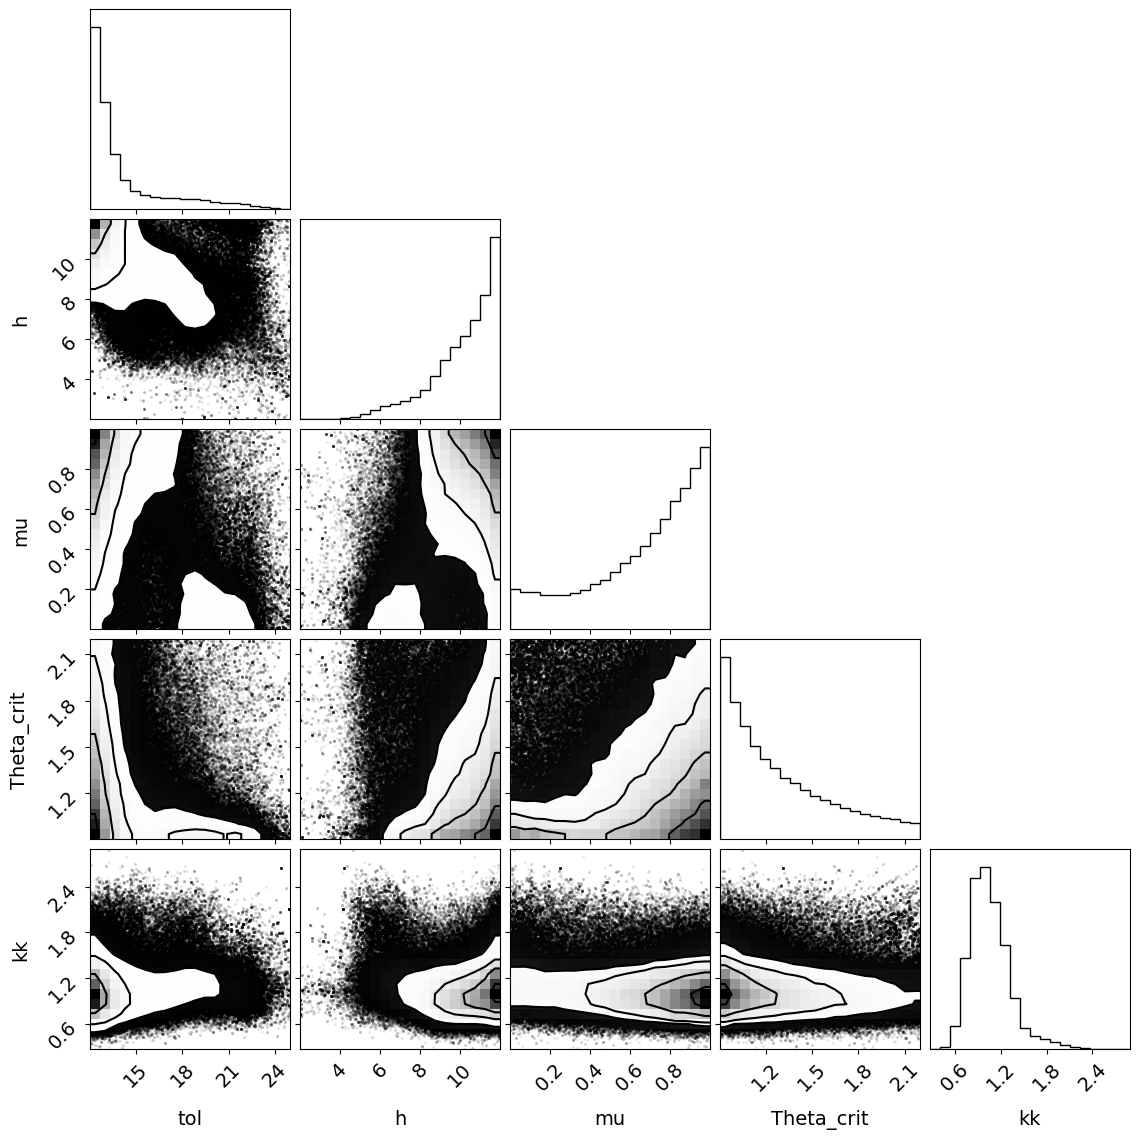

In [66]:

import warnings
import numpy as np
import emcee
import corner

# Filter out runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Function to compute likelihood
def likelihood(X, y, f):
    ##sigma_1 = 645 #rms error for area gp
    sigma_2 = 0.1 #rms error for distance gp
    y_pred, err_pred = f(X)  # Predicted output from the function f
    # Assuming Gaussian likelihood
    ### Old likelihood: likelihood = (1/(sigma_1*np.sqrt(2*np.pi)))*np.exp(-0.5 * np.sum(((y - y_pred)**2)/(sigma_1**2)))*(1/(sigma_2*np.sqrt(2*np.pi)))*np.exp(-0.5 * np.sum(((err_pred)**2)/(sigma_2**2))),   # Likelihood function
    likelihood = (1/(sigma_2*np.sqrt(2*np.pi)))*np.exp(-0.5 * np.sum(((err_pred-1.3778578922247107)**2)/(sigma_2**2))),   # Likelihood function with just Error Prediction

    return likelihood

# Function to compute log posterior
def log_posterior(X, y, f, prior_distributions):
    # Prior probabilities for each input variable in X

    prior_probs = [extract_first_item(prior.pdf(x)) for prior, x in zip(prior_distributions, X)]

    # Compute the likelihood
    likelihood_val = likelihood(X, y, f)
    # Compute the log posterior
    log_posterior_val = np.sum(np.log(prior_probs)) + np.log(likelihood_val)

    return log_posterior_val

# Define your function f that maps inputs X to output y
def f(X):

    y_pred = gp_1.predict(X.reshape(1, -1))
    err_pred = gp_2.predict(X.reshape(1, -1))
    return y_pred, err_pred

from scipy.stats import uniform
from scipy.stats import norm



tol_prior = uniform(loc=15, scale=25 - 15)
h_prior = uniform(loc=2, scale=12 - 2)
mu_prior = uniform(loc=0.0, scale = 1.0 - 0.0)
Theta_crit_prior = uniform(loc=0.9, scale=2.2-0.9)
kk_prior = kk_prior

prior_distributions = [tol_prior, h_prior, mu_prior, Theta_crit_prior, kk_prior]

# Define the measured output y
y_observed = 4018.853198 # measured area growth value

# Initialize MCMC sampler
nwalkers = 100  # Number of walkers
ndim = 5  # Dimensionality of the parameter space
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(y_observed, f, prior_distributions))

# Run MCMC sampling
nsteps = 10000  # Number of MCMC steps
# Generate random numbers for each column
column1 = np.random.uniform(12, 25, 100)
column2 = np.random.uniform(2, 12, 100)
column3 = np.random.uniform(0.0, 1.0, 100)
column4 = np.random.uniform(0.9, 2.2, 100)
column5 = starting_k_samples
# Stack the columns horizontally to create the array

array = np.column_stack((column1, column2, column3, column4, column5))

# Repeat the vector 100 times
initial_positions = array # Initial positions for walkers
step_count = 0

while step_count < nsteps:
    # Run MCMC for a subset of steps
    sampler.run_mcmc(initial_positions, nsteps=1000)


    # Increment step count
    step_count += 1000

    # You can perform any desired operations or monitoring here
    # Example: Print the current step count every 100 steps
    print(f"Completed {step_count} steps out of {nsteps}")

# Extract samples from the sampler
samples = sampler.chain[:, :, :].reshape((-1, ndim))

# Extract samples from the sampler
pair_plot_samples = sampler.get_chain(flat=True)

# Create a pair plot
fig = corner.corner(pair_plot_samples, labels=["tol", "h", "mu", "Theta_crit", "kk"],
                    truths=[None, None, None, None, None])

# Show the plot
plt.show()

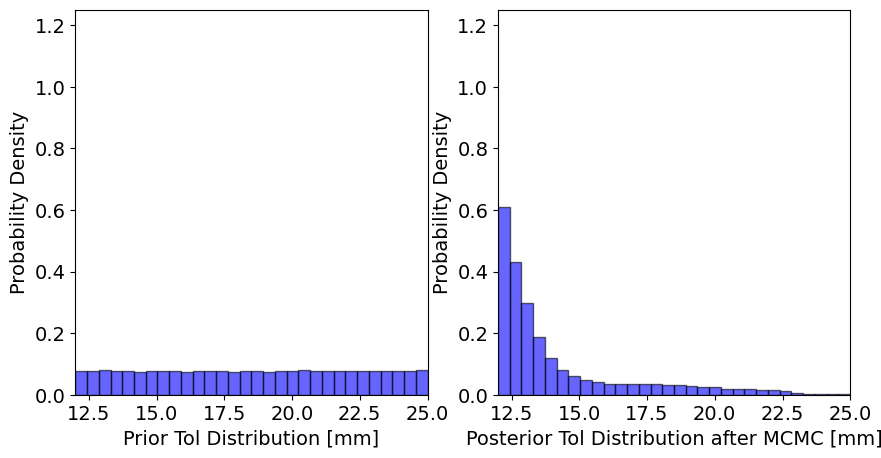

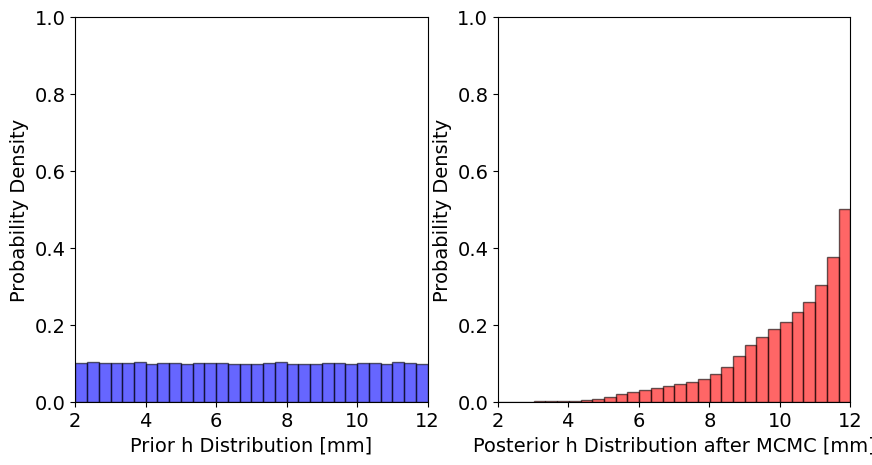

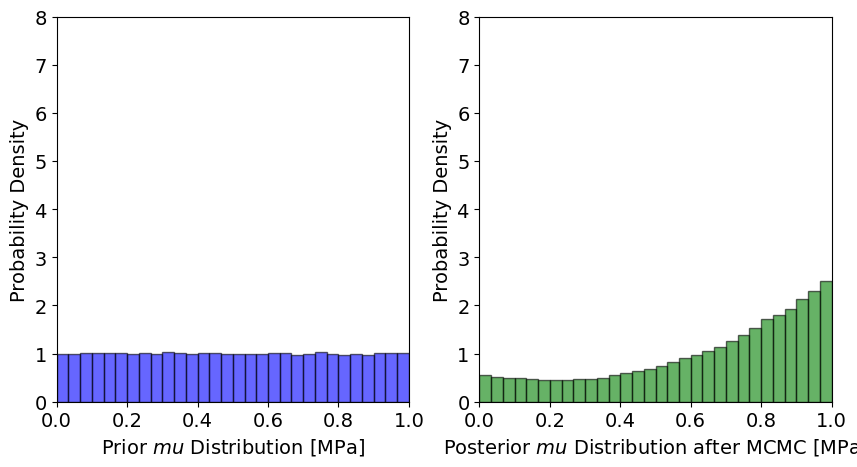

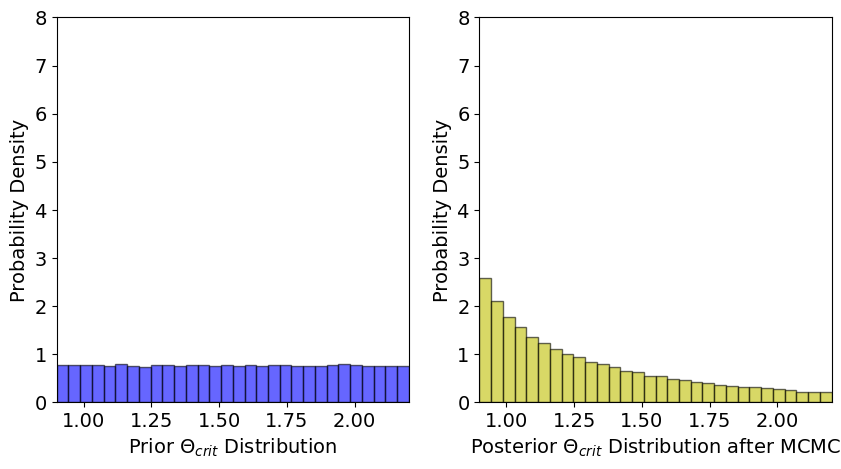

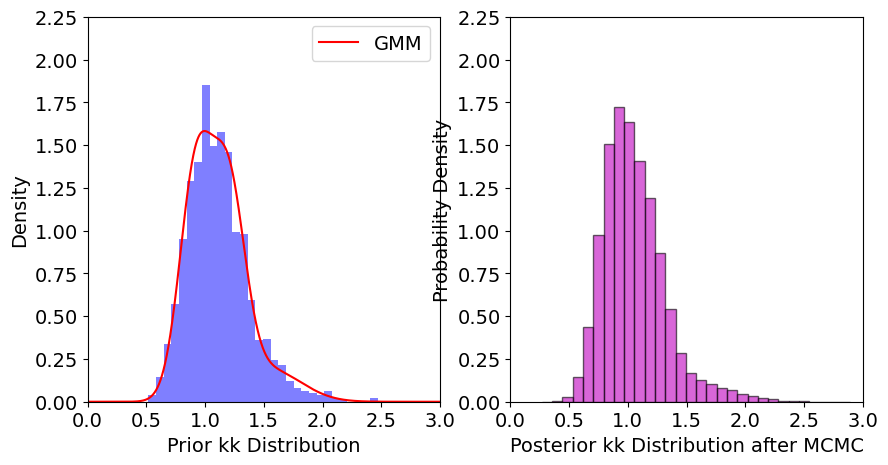

In [68]:
import matplotlib.pyplot as plt

# Extract samples for each input variable
posterior_tol = samples[:, 0]  # Samples for the first input variable
posterior_h = samples[:, 1]  # Samples for the second input variable
posterior_mu = samples[:, 2]  # Samples for the third input variable
posterior_theta_crit = samples[:, 3]  # Samples for the fourth input variable
posterior_kk = samples[:, 4]  # Samples for the fifth input variable
# Plot histograms of the samples

tol_uniform_samples = np.random.uniform(low=12, high=25, size=100000)
h_uniform_samples = np.random.uniform(low=2, high=12, size=100000)
mu_uniform_samples = np.random.uniform(low=0.0, high=1.0, size=100000)
#Theta_Crit_lognormal_samples = np.log(np.random.lognormal(mean=mean, sigma=sigma, size=100000))
Theta_Crit_lognormal_samples = np.random.uniform(low=0.9, high=2.2, size=100000)
sigma_2_samples = np.random.uniform(low=0.05, high=2, size=100000)

#Plot Tol Prior and Posterior Distributions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(tol_uniform_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs[0].set_xlabel('Prior Tol Distribution [mm]')
axs[0].set_ylabel('Probability Density')
axs[0].set_xlim([12, 25])
axs[0].set_ylim([0, 1.25])

axs[1].hist(posterior_tol, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
axs[1].set_xlabel('Posterior Tol Distribution after MCMC [mm]')
axs[1].set_ylabel('Probability Density')
axs[1].set_xlim([12, 25])
axs[1].set_ylim([0, 1.25])
plt.show()

#Plot h Prior and Posterior Distributions
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))
axs2[0].hist(h_uniform_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs2[0].set_xlabel('Prior h Distribution [mm]')
axs2[0].set_ylabel('Probability Density')
axs2[0].set_xlim([2, 12])
axs2[0].set_ylim([0, 1])


axs2[1].hist(posterior_h, bins=30, density=True, alpha=0.6, color='r', edgecolor='black')
axs2[1].set_xlabel('Posterior h Distribution after MCMC [mm]')
axs2[1].set_ylabel('Probability Density')
axs2[1].set_xlim([2, 12])
axs2[1].set_ylim([0, 1])

#Plot mu Prior and Posterior Distributions
fig3, axs3 = plt.subplots(1, 2, figsize=(10, 5))
axs3[0].hist(mu_uniform_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs3[0].set_xlabel('Prior $mu$ Distribution [MPa]')
axs3[0].set_ylabel('Probability Density')
axs3[0].set_xlim([0, 1])
axs3[0].set_ylim([0, 8])

axs3[1].hist(posterior_mu, bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
axs3[1].set_xlabel('Posterior $mu$ Distribution after MCMC [MPa]')
axs3[1].set_ylabel('Probability Density')
axs3[1].set_xlim([0, 1])
axs3[1].set_ylim([0, 8])

#Plot Theta Crit Prior and Posterior Distributions
fig4, axs4 = plt.subplots(1, 2, figsize=(10, 5))
axs4[0].hist(Theta_Crit_lognormal_samples, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
axs4[0].set_xlabel('Prior $\Theta_{{crit}}$ Distribution')
axs4[0].set_ylabel('Probability Density')
axs4[0].set_xlim([0.9, 2.2])
axs4[0].set_ylim([0, 8])


axs4[1].hist(posterior_theta_crit, bins=30, density=True, alpha=0.6, color='y', edgecolor='black')
axs4[1].set_xlabel('Posterior $\Theta_{{crit}}$ Distribution after MCMC')
axs4[1].set_ylabel('Probability Density')
axs4[1].set_xlim([0.9, 2.2])
axs4[1].set_ylim([0, 8])
plt.show()


fig5, axs5 = plt.subplots(1, 2, figsize=(10, 5))
x = np.linspace(0, 3, 10000)
density = gmm.pdf(x)
axs5[0].hist(data, bins=30, density=True, alpha=0.5, color='blue')
axs5[0].plot(x, density, color='red', label='GMM')
axs5[0].set_xlim([0,3])
axs5[0].set_ylim([0, 2.25])
axs5[0].set_xlabel('Prior kk Distribution')
axs5[0].set_ylabel('Density')
axs5[0].legend()

axs5[1].hist(posterior_kk, bins=30, density=True, alpha=0.6, color='m', edgecolor='black')
axs5[1].set_xlim([0,3])
axs5[1].set_ylim([0, 2.25])
axs5[1].set_xlabel('Posterior kk Distribution after MCMC')
axs5[1].set_ylabel('Probability Density')

plt.show()

